In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [21]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import seaborn as sns
from scipy.interpolate import interp1d
import uproot
from helpers import helpfunction as helper

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

In [4]:
# load the splines
numu_spline = uproot.open("./input/splines/numu_v13_v12_Ratio.root")
nue_spline = uproot.open("./input/splines/nue_v13_v12_Ratio.root")
spline_x = numu_spline["Graph"].__dict__["_fX"]
spline_y_numu = numu_spline["Graph"].__dict__["_fY"]
spline_y_nue = nue_spline["Graph"].__dict__["_fY"]
spline_y = {"nu": spline_y_numu, "nue": spline_y_nue}

<IPython.core.display.Javascript object>

In [5]:
input_dir = "./input/16Jan/"
output_dir = "./output/systematics/"
samples = ["nu", "nue"]

<IPython.core.display.Javascript object>

In [24]:
df_nue = []
df_nu = []
pot_nue = 0
pot_nu = 0

for r in [1, 3]:
    data = pickle.load(open(input_dir + "run{}_slimmed.pckl".format(r), "rb"))
    df_nue.append(pd.DataFrame.from_dict(data["nue"]["mc"]))
    pot_nue += data["nue"]["pot"]
    df_nu.append(pd.DataFrame.from_dict(data["nu"]["mc"]))
    pot_nu += data["nu"]["pot"]
    del data
df_nu = pd.concat(df_nu).query("abs(nu_pdg)==14 & ccnc==0")
df_nu["fv"] = helper.is_tpc(
    *df_nu[["true_nu_vtx_x", "true_nu_vtx_y", "true_nu_vtx_z"]].values.T
)
df_nue = pd.concat(df_nue).query("abs(nu_pdg)==12 & ccnc==0")
df_nue["fv"] = helper.is_tpc(
    *df_nue[["true_nu_vtx_x", "true_nu_vtx_y", "true_nu_vtx_z"]].values.T
)
gc.collect()

9376

<IPython.core.display.Javascript object>

In [25]:
df_nue.keys()

Index(['mc_pdg', 'mc_E', 'lep_e', 'ccnc', 'theta', 'true_nu_vtx_x',
       'true_nu_vtx_y', 'true_nu_vtx_z', 'n_pfps', 'interaction',
       'weightSpline', 'weightSplineTimesTune', 'leeweight', 'category',
       'nu_e', 'nu_pdg', 'nelec', 'npion', 'npi0', 'nproton', 'nmuon',
       'nu_completeness_from_pfp', 'nu_purity_from_pfp', 'nueccinc',
       'true_category', 'fv'],
      dtype='object')

<IPython.core.display.Javascript object>

In [41]:
mass_mu = 0.106
mass_e = 0
sig = "nu"
pdg_sig = 14
mass = mass_mu
pot_target = 1e21
scale_nue = pot_target / pot_nue
scale_nu = pot_target / pot_nu

<IPython.core.display.Javascript object>

In [27]:
fields_arr = ["nu_e", "lep_e", "theta"]
xmin_arr = [mass, mass, 0]
xmax_arr = [3, 3, np.pi]
bins_arr = [20, 40, 40]
xlab_arr = [r"$\nu$ Energy [GeV]", "Lepton Energy [GeV]", r"Lepton $\theta$ Angle"]

<IPython.core.display.Javascript object>

In [28]:
df_nue.head()

,mc_pdg,mc_E,lep_e,ccnc,theta,true_nu_vtx_x,true_nu_vtx_y,true_nu_vtx_z,n_pfps,interaction,...,nelec,npion,npi0,nproton,nmuon,nu_completeness_from_pfp,nu_purity_from_pfp,nueccinc,true_category,fv
0,"[11, 2212]","[0.6238746, 1.1427704]",0.623875,0,0.604961,239.136566,57.772831,671.183838,4,0,...,1,0,0,1,0,0.582267,0.950746,True,2,True
1,"[11, 2212, 211]","[0.67638135, 1.0654515, 0.38684997]",0.676381,0,0.955900,27.003010,-72.006500,802.035034,3,1,...,1,1,0,1,0,0.796931,0.966083,True,3,True
2,"[11, 2212, 2212, 2212, 2212, 2212, 2212, 2112,...","[0.6592401, 0.95400673, 1.0053468, 0.95249236,...",0.659240,0,0.554899,217.622192,62.526608,348.015228,0,2,...,1,2,0,1,0,0.796931,0.966083,True,3,True
3,"[11, 2112, 2212, 2212]","[0.276036, 1.016515, 0.9947159, 1.2012972]",0.276036,0,0.566472,66.891975,104.749962,335.488220,2,10,...,1,0,0,2,0,0.894977,0.246231,True,2,True
4,"[11, 2212]","[1.0833725, 0.99056]",1.083372,0,0.377220,7.580218,37.223171,638.651672,3,0,...,1,0,0,1,0,0.969208,0.953824,False,6,False


<IPython.core.display.Javascript object>

In [29]:
# Fix weighting problems:
df_nue["weightSplineTimesTune"] = np.nan_to_num(df_nue["weightSplineTimesTune"])
df_nu["weightSplineTimesTune"] = np.nan_to_num(df_nu["weightSplineTimesTune"])

<IPython.core.display.Javascript object>

In [30]:
# give weights using the splines
mids_spline_x = (spline_x[1:] + spline_x[:-1]) / 2
bins_spline_x = np.array([0] + list(mids_spline_x))
bins_spline_y_numu = np.array(list(spline_y_numu) + [spline_y_numu[-1]])
bins_spline_y_nue = np.array(list(spline_y_nue) + [spline_y_nue[-1]])

<IPython.core.display.Javascript object>

In [31]:
df_nu["mcc8"] = 1 / bins_spline_y_numu[np.digitize(df_nu["nu_e"], bins_spline_x)]
df_nue["mcc8"] = 1 / bins_spline_y_nue[np.digitize(df_nue["nu_e"], bins_spline_x)]

<IPython.core.display.Javascript object>

In [54]:
(sum(df_nue.eval("fv*weightSpline")) / pot_nue) / (
    sum(df_nu.eval("fv*weightSpline")) / pot_nu
) * 100

0.6630483179452628

<IPython.core.display.Javascript object>

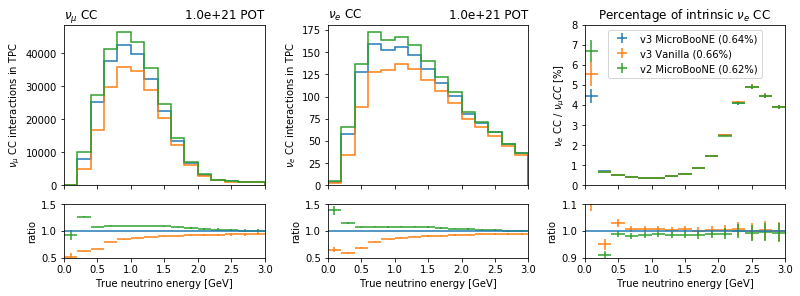

<IPython.core.display.Javascript object>

In [100]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(11, 4),
    sharex=True,
    constrained_layout=True,
    gridspec_kw={"height_ratios": [3, 1]},
)

x_min = min(spline_x)
x_max = 3.0
N_bins = 15

nu_v3_ub = 0
nue_v3_ub = 0
r_nue_nu_v3_ub = 0

for weight, lab in zip(
    ["weightSplineTimesTune", "weightSpline", "mcc8"],
    ["v3 MicroBooNE", "v3 Vanilla", "v2 MicroBooNE"],
):
    nu, edges, _ = ax[0][0].hist(
        df_nu.query("fv")["nu_e"],
        range=(x_min, x_max),
        bins=N_bins,
        histtype="step",
        weights=df_nu.query("fv")[weight] * scale_nu,
        lw=1.5,
    )
    nue, edges, _ = ax[0][1].hist(
        df_nue.query("fv")["nu_e"],
        range=(x_min, x_max),
        bins=N_bins,
        histtype="step",
        weights=df_nue.query("fv")[weight] * scale_nue,
        lw=1.5,
    )

    r_tot = (df_nue.query("fv")[weight].sum() / pot_nue) / (
        df_nu.query("fv")[weight].sum() / pot_nu
    )
    edges_mid = (edges[1:] + edges[:-1]) / 2
    widths = (edges[1:] - edges[:-1]) / 2
    r_nue_nu = nue / nu
    err_r = r_nue_nu * np.sqrt(scale_nue / nue + scale_nu / nu)
    ax[0][2].errorbar(
        edges_mid,
        r_nue_nu * 100,
        yerr=err_r * 100,
        xerr=widths,
        fmt="none",
        label=lab + " ({:.2%})".format(r_tot),
    )

    # ratios
    if lab == "v3 MicroBooNE":
        nu_v3_ub = nu
        nue_v3_ub = nue
        r_nue_nu_v3_ub = r_nue_nu
        ax[1][0].plot([x_min, x_max], [1, 1])
        ax[1][1].plot([x_min, x_max], [1, 1])
        ax[1][2].plot([x_min, x_max], [1, 1])
    else:
        r_nu = nu / nu_v3_ub
        err_r_nu = r_nu * np.sqrt(scale_nu / nu + scale_nu / nu_v3_ub)
        ax[1][0].errorbar(edges_mid, r_nu, yerr=err_r_nu, xerr=widths, fmt="none")

        r_nue = nue / nue_v3_ub
        err_r_nue = r_nue * np.sqrt(scale_nue / nue + scale_nue / nue_v3_ub)
        ax[1][1].errorbar(edges_mid, r_nue, yerr=err_r_nue, xerr=widths, fmt="none")

        r_r_nu_nue = (nue / nu) / r_nue_nu_v3_ub
        r1 = r_nue_nu * np.sqrt(scale_nue / nue + scale_nu / nu)
        r2 = r_nue_nu_v3_ub * np.sqrt(scale_nue / nue_v3_ub + scale_nu / nu_v3_ub)
        err_final = r_r_nu_nue * np.sqrt(
            (r1 / (nue / nu)) ** 2 + (r2 / (r_nue_nu_v3_ub)) ** 2
        )
        ax[1][2].errorbar(
            edges_mid, r_r_nu_nue, yerr=err_final, xerr=widths, fmt="none"
        )


ax[1][0].set_xlabel(r"True neutrino energy [GeV]")
ax[1][1].set_xlabel(r"True neutrino energy [GeV]")
ax[1][2].set_xlabel(r"True neutrino energy [GeV]")
ax[0][0].set_title(r"$\nu_\mu$ CC", loc="left")
ax[0][0].set_title(r"{:0.1e} POT".format(pot_target), loc="right")
ax[0][1].set_title(r"$\nu_e$ CC", loc="left")
ax[0][1].set_title(r"{:0.1e} POT".format(pot_target), loc="right")
ax[0][0].set_ylabel(r"$\nu_\mu$ CC interactions in TPC")
ax[0][1].set_ylabel(r"$\nu_e$ CC interactions in TPC")
ax[0][2].set_ylabel(r"$\nu_e$ CC / $\nu_\mu CC$ [%]")
ax[0][2].set_title(r"Percentage of intrinsic $\nu_e$ CC")
ax[0][0].set_xlim(x_min, x_max)
ax[0][2].set_ylim(0, 8)
ax[0][2].legend(loc="upper center")

ax[1][0].set_ylabel("ratio")
ax[1][1].set_ylabel("ratio")
ax[1][2].set_ylabel("ratio")

ax[1][0].set_ylim(0.5, 1.5)
ax[1][1].set_ylim(0.5, 1.5)
ax[1][2].set_ylim(0.9, 1.1)

fig.savefig(output_dir + "splines.pdf", bbox_inches="tight")

Total
QE
MEC
RES
DIS


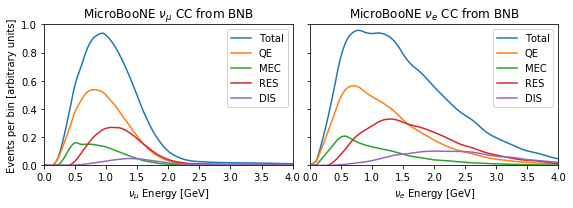

<IPython.core.display.Javascript object>

In [80]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 3), sharex=True, sharey=True)
dict_modes = {-1: "Total", 0: "QE", 10: "MEC", 1: "RES", 2: "DIS"}

for i, (int_code, name) in enumerate(dict_modes.items()):
    print(name)
    if int_code > -1:
        data_nu = df_nu.query("interaction==@int_code")
        data_nue = df_nue.query("interaction==@int_code")
    else:
        data_nu = df_nu
        data_nue = df_nue

    bins, edges = np.histogram(
        data_nu["nu_e"],
        weights=data_nu["weightSplineTimesTune"],
        bins=45,
        range=(0, 4.08),
    )
    mids = (edges[1:] + edges[:-1]) / 2

    f = interp1d(mids, bins / 150000, kind="quadratic")
    xnew = np.linspace(mids[0], mids[-1], num=300, endpoint=True)
    ax[0].plot([0] + list(xnew), [0] + list(f(xnew)), label=name)
    bins, edges = np.histogram(
        data_nue["nu_e"],
        weights=data_nue["weightSplineTimesTune"],
        bins=20,
        range=(0, 4.2),
    )
    mids = (edges[1:] + edges[:-1]) / 2
    f = interp1d(mids, bins / 27000, kind="quadratic")
    xnew = np.linspace(mids[0], mids[-1], num=300, endpoint=True)
    ax[1].plot([0] + list(xnew), [0] + list(f(xnew)), label=name)

ax[0].legend()
ax[1].legend()
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
ax[0].set_xlim(0, 4)
ax[1].set_xlim(0, 4)
ax[0].set_xlabel(r"$\nu_\mu$ Energy [GeV]")
ax[1].set_xlabel(r"$\nu_e$ Energy [GeV]")
ax[0].set_ylabel("Events per bin [arbitrary units]")

ax[0].set_title(r"MicroBooNE $\nu_\mu$ CC from BNB")
ax[1].set_title(r"MicroBooNE $\nu_e$ CC from BNB")

fig.tight_layout()
fig.savefig(output_dir + "int_modes_true.pdf", bbox_inches="tight")

In [16]:
run_labs = ["Genie 3 Vanilla", "SplineWeight", "Spline*Tune"]
run_qs = ["nmuon", "weightSpline", "weightSplineTimesTune"]

<IPython.core.display.Javascript object>

{'Genie 3 Vanilla': array([  440.,  9241., 27008., 42254., 51168., 52562., 47963., 40278.,
       31593., 22358., 14419.,  8626.,  4938.,  2648.,  1480.,   999.,
         741.,   588.,   549.,   465.]), 'SplineWeight': array([ 1414.70690918, 13794.15429688, 32787.85546875, 46484.38671875,
       53054.5078125 , 52616.90234375, 47141.95703125, 39179.41015625,
       30564.79296875, 21627.22460938, 13942.91992188,  8350.68066406,
        4779.91650391,  2567.21533203,  1434.56628418,   969.72137451,
         719.22442627,   571.95776367,   533.28601074,   451.36422729]), 'Spline*Tune': array([ 2525.70117188, 19630.20703125, 42932.546875  , 59295.76171875,
       67122.875     , 66422.3359375 , 59568.37109375, 49621.20703125,
       38869.8984375 , 27554.85351562, 17793.45117188, 10669.08398438,
        6113.81689453,  3292.13061523,  1834.39819336,  1252.01245117,
         924.32574463,   735.39416504,   678.93395996,   578.98443604])}
{'Genie 3 Vanilla': array([0.0000e+00, 1.2000e+01, 1

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


{'Genie 3 Vanilla': array([   0.,   10.,  219.,  808., 1756., 2946., 4130., 5307., 5997.,
       5842., 5116., 4030., 2840., 1917., 1373., 1025.,  927.,  845.,
        845.,  857.]), 'SplineWeight': array([   0.,   14.,  238.,  825., 1788., 2991., 4190., 5373., 6064.,
       5896., 5160., 4051., 2855., 1929., 1385., 1028.,  930.,  846.,
        847.,  860.]), 'Spline*Tune': array([   0.,   14.,  238.,  825., 1788., 2991., 4190., 5373., 6064.,
       5896., 5160., 4051., 2855., 1929., 1385., 1028.,  930.,  846.,
        847.,  860.])}
{'Genie 3 Vanilla': array([  233.,  1892.,  4970.,  8861., 12248., 13415., 12910., 10781.,
        8402.,  5921.,  3769.,  2283.,  1333.,   740.,   392.,   255.,
         218.,   170.,   164.,   119.]), 'SplineWeight': array([  254.,  1931.,  5063.,  8948., 12294., 13436., 12930., 10796.,
        8402.,  5921.,  3769.,  2283.,  1333.,   740.,   392.,   255.,
         218.,   170.,   164.,   119.]), 'Spline*Tune': array([  249.63119507,  7137.48730469, 1937

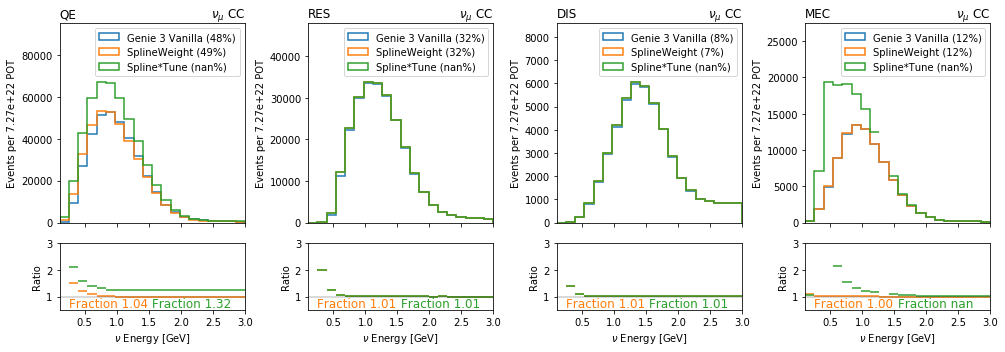

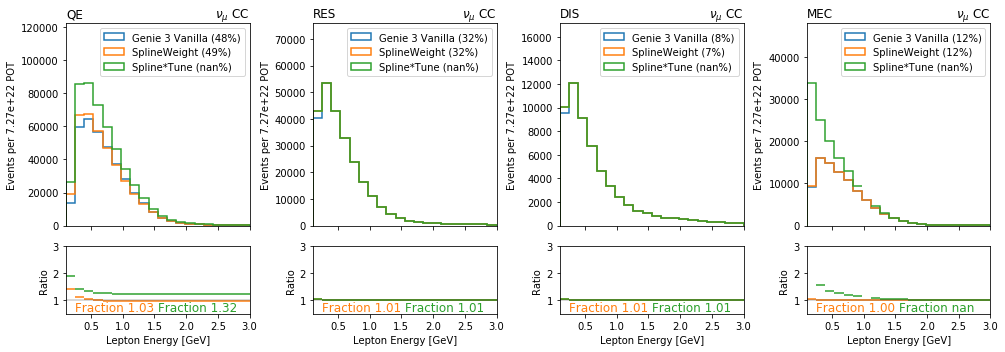

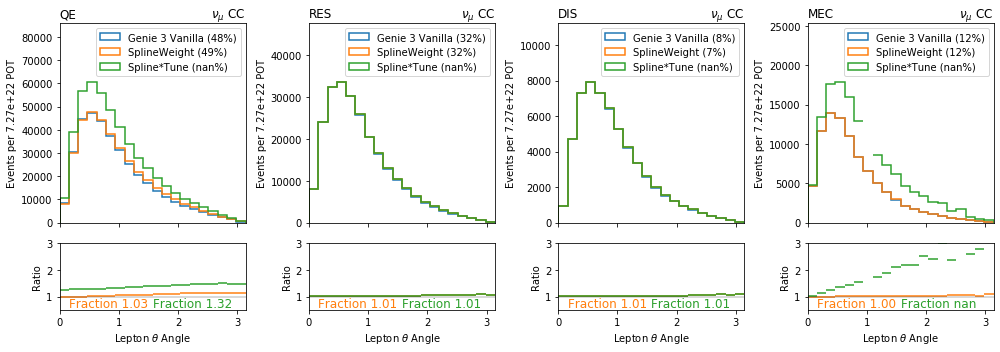

<IPython.core.display.Javascript object>

In [17]:
dict_modes = {0: "QE", 1: "RES", 2: "DIS", 10: "MEC"}
bins_arr = [20, 20, 20]

for field, xmin, xmax, bins, xlab in zip(
    fields_arr, xmin_arr, xmax_arr, bins_arr, xlab_arr
):
    fig, ax = plt.subplots(
        ncols=4,
        nrows=2,
        figsize=(14, 5),
        gridspec_kw={"height_ratios": [3, 1]},
        sharex="col",
    )
    for i, (int_code, name) in enumerate(dict_modes.items()):
        bin_vals = {}
        for (run_lab, run_q) in zip(run_labs, run_qs):
            data = df_nu.query(
                "abs(nu_pdg)==@pdg_sig & ccnc==0 & interaction==@int_code"
            )[field]
            weights = df_nu.query(
                "abs(nu_pdg)==@pdg_sig & ccnc==0 & interaction==@int_code"
            )[run_q]

            denom = sum(df_nu.query("abs(nu_pdg)==@pdg_sig & ccnc==0")[run_q])

            percent = sum(weights) / denom * 100
            vals, edges, _ = ax[0][i].hist(
                data,
                label=run_lab + " ({:.0f}%)".format(percent),
                weights=weights,
                range=(xmin, xmax),
                bins=bins,
                lw=1.5,
                histtype="step",
            )
            bin_vals[run_lab] = vals
        ax[0][i].set_ylabel("Events per {:.3g} POT".format(pot_nue))
        ax[0][i].legend(ncol=1, loc="upper right")
        ax[0][i].set_title(name, loc="left")
        if pdg_sig == 12:
            ax[0][i].set_title(r"$\nu_e$ CC", loc="right")
        if pdg_sig == 14:
            ax[0][i].set_title(r"$\nu_\mu$ CC", loc="right")
        ax[0][i].set_xlim(xmin, xmax)
        ax[0][i].set_ylim(0, ax[0][i].get_ylim()[1] * 1.35)

        print(bin_vals)
        # ratio
        ax[1][i].set_xlabel(xlab)
        ax[1][i].set_ylabel("Ratio")
        mids = (edges[1:] + edges[:-1]) / 2
        xerr = (edges[1:] - edges[:-1]) / 2
        # yerr = np.sqrt(1/ bin_vals[r]) for r in run_labs]))
        ax[1][i].errorbar(
            mids,
            bin_vals[run_labs[1]] / bin_vals[run_labs[0]],
            xerr=xerr,
            fmt="none",
            color="C1",
        )
        ax[1][i].errorbar(
            mids,
            bin_vals[run_labs[2]] / bin_vals[run_labs[0]],
            xerr=xerr,
            fmt="none",
            color="C2",
        )
        ax[1][i].axhline(y=1, alpha=0.2, color="k")
        ax[1][i].set_ylim(0.5, 3)
        text_x = xmin + (xmax - xmin) * 0.05
        fraq = sum(bin_vals[run_labs[1]]) / sum(bin_vals[run_labs[0]])
        ax[1][i].text(
            text_x, 0.6, "Fraction {:.2f}".format(fraq), fontsize=12, color="C1"
        )
        text_x = xmin + (xmax - xmin) * 0.5
        fraq = sum(bin_vals[run_labs[2]]) / sum(bin_vals[run_labs[0]])
        ax[1][i].text(
            text_x, 0.6, "Fraction {:.2f}".format(fraq), fontsize=12, color="C2"
        )

    fig.tight_layout()
    fig.savefig(output_dir + field + "_" + sig + "_xsec_zoom.pdf", bbox_inches="tight")